In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
starting_period = "2011-01-01"
end_period = '2023-01-01'
ticker = 'GOOG'

[*********************100%***********************]  1 of 1 completed


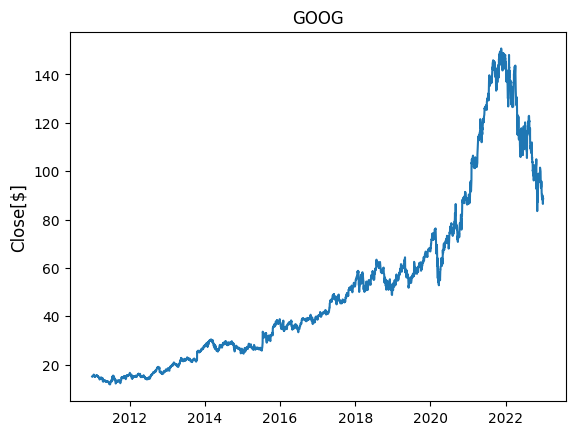

In [3]:
raw_data = yf.download(tickers=ticker, start=starting_period, end=end_period)
plt.plot(raw_data.index, raw_data['Close'])
plt.title(ticker)
plt.ylabel('Close[$]',fontsize=12)
plt.show()

### Making buy/sell labels for data

In [4]:
df = raw_data.reset_index()
buy_sell = []

# in how much + days we want to act on signal.
day_offset = 10

for i in range(0,len(df)- day_offset):
    
    # check whether return was positive/negative
    stopa_zwrotu = df.iloc[i + day_offset]['Close']/ df.iloc[i]['Close'] - 1 
    if stopa_zwrotu > 0.0:
        buy_sell.append(1)
    else:
        buy_sell.append(0)

In [5]:
df_labeled = df.iloc[0:len(df)-10]
df_labeled['Return'] = df_labeled['Close']/df_labeled['Open'] - 1
df_labeled['Buy/Sell'] = buy_sell

In [6]:
df_labeled.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Buy/Sell
0,2011-01-03,14.856315,15.083214,14.856315,15.052330,15.052330,94962614,0.013194,1
1,2011-01-04,15.083962,15.097909,14.946975,14.996788,14.996788,73253547,-0.005779,1
2,2011-01-05,14.945730,15.201272,14.945232,15.169890,15.169890,101671667,0.014998,1
3,2011-01-06,15.209989,15.403016,15.194298,15.280226,15.280226,82620526,0.004618,0
4,2011-01-07,15.340251,15.398533,15.196291,15.353451,15.353451,84363033,0.000860,0


### Preparing lagged data_frame for ML model

In [7]:
# determins t-n period eg. 7 means that data from t-7 days are considered as input to model
historical_offset = 7
volatility_offset = 30

data = {'Date': [], 'Buy/Sell': [], f'Volatility{volatility_offset}': [], f'Mean{historical_offset}': [], f'max-min{historical_offset}': []}
variables = ['Close', 'Open', 'High', 'Low', 'Volume']

# adds t-n varaibles to data dictionary
for var in variables:  
    for i in range(0, historical_offset):
        var_label = f't-{i}_{var.lower()}'
        data[var_label] = []

# fills data dictionary and creates data set for ML model       
for row in range(volatility_offset, len(df_labeled)):

    # date
    date = df_labeled.iloc[row]['Date']
    data['Date'].append(date)
    
    # buy/sell
    signal = df_labeled.iloc[row]['Buy/Sell']
    data['Buy/Sell'].append(signal)
    
    # mean
    window_data = df_labeled.iloc[(row - historical_offset): row]
    mean = np.mean(window_data['Return'])
    data[f'Mean{historical_offset}'].append(mean)
    
    # volatility
    window_data_volatility = df_labeled.iloc[(row - volatility_offset): row]
    std = np.std(window_data['Return'])
    data[f'Volatility{volatility_offset}'].append(std)
    
    # delta price |max - min|
    delta_price = (window_data['Return'].max() - window_data['Return'].min())
    data[f'max-min{historical_offset}'].append(delta_price)
    
    
    # other variables like t-0_close, t-2_low etc.
    for var in variables:
        for i in range(0, historical_offset):
            label = label = f't-{i}_{var.lower()}'
            value = df_labeled.iloc[row - i][var]
            data[label].append(value)
            
data_for_model = pd.DataFrame(data)

# adds weekday variable
data_for_model['day_of_week'] = data_for_model['Date'].dt.weekday

In [8]:
data_for_model.head(1)

,Date,Buy/Sell,Volatility30,Mean7,max-min7,t-0_close,t-1_close,t-2_close,t-3_close,t-4_close,...,t-5_low,t-6_low,t-0_volume,t-1_volume,t-2_volume,t-3_volume,t-4_volume,t-5_volume,t-6_volume,day_of_week
0,2011-02-15,0,0.005389,0.006063,0.018049,15.545482,15.645108,15.554199,15.353451,15.354946,...,15.305382,15.173376,83993653,85439051,103984303,93725996,73976246,68050116,72253814,1


In [9]:
extra_features = ['day_of_week', f'Volatility{volatility_offset}', f'Mean{historical_offset}', f'max-min{historical_offset}']

# Time series data split

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
data_for_time_series = data_for_model.set_index('Date')
n_splits = 3
tss = TimeSeriesSplit(n_splits = n_splits)
X = data_for_time_series.drop(labels= extra_features + ['Buy/Sell'], axis=1)
y = data_for_time_series['Buy/Sell']
data_plot = []
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    data_plot.append([y_test, X_test, y_train, X_train])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


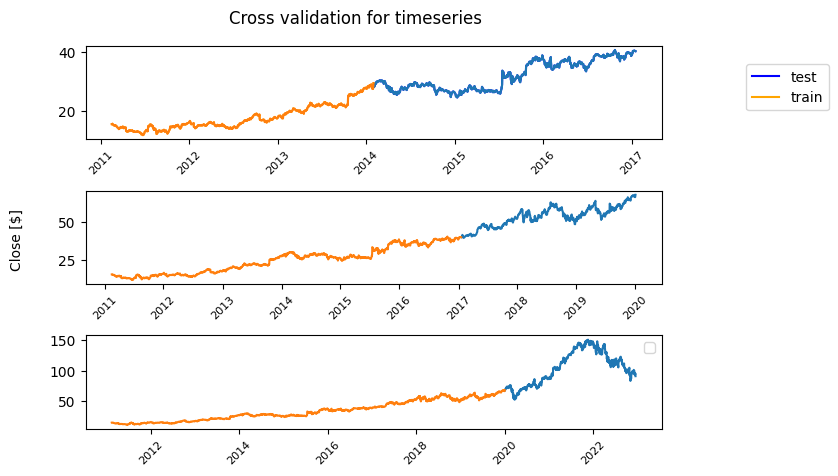

In [11]:
fig, axs = plt.subplots(3)
fig.suptitle('Cross validation for timeseries')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
line1, = axs[0].plot(data_plot[0][0].index, data_plot[0][1][f't-0_close'], color='blue')
line2, = axs[0].plot(data_plot[0][2].index, data_plot[0][3][f't-0_close'], color='orange')
axs[0].plot(data_plot[0][0].index, data_plot[0][1][f't-0_close'], label='X_test')
axs[0].plot(data_plot[0][2].index, data_plot[0][3][f't-0_close'])
axs[1].plot(data_plot[1][0].index, data_plot[1][1][f't-0_close'])
axs[1].plot(data_plot[1][2].index, data_plot[1][3][f't-0_close'])
axs[2].plot(data_plot[2][0].index, data_plot[2][1][f't-0_close'])
axs[2].plot(data_plot[2][2].index, data_plot[2][3][f't-0_close'])

for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_fontsize(8)
        
fig.legend([line1, line2], ['test', 'train'], bbox_to_anchor=(1.25, 0.88))        
fig.text(-0.04, 0.5, 'Close [$]', va='center', rotation='vertical')
plt.tight_layout(pad=1.0)  # Adjust padding between and around subplots
plt.legend()
plt.show()

# SVM model for classification

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np


data_for_time_series = data_for_model.set_index('Date')
n_splits = 3
tss = TimeSeriesSplit(n_splits = n_splits)
X = data_for_time_series.drop(labels= extra_features + ['Buy/Sell'], axis=1)
y = data_for_time_series['Buy/Sell']

accuracys = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = SVC()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)


    accuracy = accuracy_score(y_test, predictions)
    accuracys.append(accuracy)

print(f"Model oveall accuracy {np.mean(accuracys)}")

Model oveall accuracy 0.5713646532438479


### Random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
data_for_time_series = data_for_model.set_index('Date')
n_splits = 3
tss = TimeSeriesSplit(n_splits = n_splits)
X = data_for_time_series.drop(labels= extra_features + ['Buy/Sell'], axis=1)
y = data_for_time_series['Buy/Sell']

accuracys = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=600)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)


    accuracy = accuracy_score(y_test, predictions)
    accuracys.append(accuracy)

print(f"Model oveall accuracy {np.mean(accuracys)}")

Model oveall accuracy 0.4917225950782998


### Adding features (from previous feature engineering)

In [23]:
# SVM
data_for_time_series = data_for_model.set_index('Date')
n_splits = 3
tss = TimeSeriesSplit(n_splits = n_splits)
X = data_for_time_series.drop(labels=['Buy/Sell'], axis=1) # dropping only supervised labels instead of extra features as in previous iteretions
y = data_for_time_series['Buy/Sell']

accuracys = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = SVC()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)


    accuracy = accuracy_score(y_test, predictions)
    accuracys.append(accuracy)

print(f"Model oveall accuracy {np.mean(accuracys)}")

Model oveall accuracy 0.5713646532438479


In [22]:
# Random forest
data_for_time_series = data_for_model.set_index('Date')
n_splits = 3
tss = TimeSeriesSplit(n_splits = n_splits)
X = data_for_time_series.drop(labels=['Buy/Sell'], axis=1)
y = data_for_time_series['Buy/Sell']

accuracys = []

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=600)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)


    accuracy = accuracy_score(y_test, predictions)
    accuracys.append(accuracy)

print(f"Model oveall accuracy {np.mean(accuracys)}")

Model oveall accuracy 0.49395973154362416


## Hyper-parameters tuning

#### RandomizedGridSearch - random forest | for computation time reasons, model is fitted only on the final split from CV (3rd plot from visualization) 

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

In [27]:
rfc = RandomForestClassifier()
# search across 50 different combinations
rfc_random_gridsearch = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rfc_random_gridsearch.fit(X_train, y_train)
predictions = rfc_random_gridsearch.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model oveall accuracy {accuracy}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model oveall accuracy 0.5355704697986577


#### Exhaustive grid search - SVM

In [29]:
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1,1, 10, 100, 1000], # parametr, który karze za misklasyfikacje pkt, małe c luzny, duże surowy
              'gamma': [1,0.1,0.01,0.001, 0.0001], # odległość pkt, które wpłwaja na mijesce granicy decyzyjnej, małe gamma dużo pkt ma wpły, duże gamma mało odległe pkt się liczą.
              'kernel': ['rbf', 'sigmoid']} # funkcje jądra przedstawiają np 2 cechy za pomocą skalara, gdzie duże wartości świadczą o podobienstwie tych cech a małe o niskim podobienstwie. 
  
grid_search = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_predictions = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, grid_predictions)
print(f"Model oveall accuracy {accuracy}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model oveall accuracy 0.5624161073825503
[CV 1/3] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.550 total time=   2.6s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.446 total time=  20.7s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=5, n_estimators=1800;, score=0.549 total time=  30.9s
[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.552 total time=  26.6s
[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.443 total time=  26.7s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=0.587 total time=  14.9s
[CV 2/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2

[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.550 total time=  18.2s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=0.455 total time=  19.4s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=5, n_estimators=1800;, score=0.587 total time=  25.2s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.587 total time=  39.2s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.584 total time=  25.6s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.585 total time=  12.4s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.552 total time=   3.5s
[CV 2/3] END bootstrap=False, max_depth=80, min_s